Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [141]:
NAME = "Arnav Sinha"
COLLABORATORS = ""

---

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\price}{{p}}
\newcommand{\ret}{{r}}
\newcommand{\tp}{{(t)}}
\newcommand{\aapl}{{\text{AAPL}}}
\newcommand{\ba}{{\text{BA}}}
\newcommand{\spy}{{\text{SPY}}}
$$

# Assignment: Using Machine Learning for Hedging

Welcome to the first assignment !

# Problem description

We will solve a Regression task that is very common in Finance
- Given the return of "the market", predict the return of a particular stock

That is
- Given the return of a proxy for "the market" at time $t$, predict the return of, e.g., Apple at time $t$.

As we will explain,
being able to predict the relationship between two financial instruments opens up possibilities
- Use one instrument to "hedge" or reduce the risk of holding the other
- Create strategies whose returns are independent of "the market"
    - Hopefully make a profit regardless of whether the market goes up or down

## Goal

You will create models of increasing complexity in order to explain the return of Apple (ticker $\aapl$)
- The first model will have a single feature: return of the market proxy, ticker $\spy$
- Subsequent models will add the return of other tickers as additional features

## Learning Objectives
- Learn how to solve a Regression task
- Become facile in the `sklearn` toolkit for Machine Learning

## How to report your answers
We will mix explanation of the topic with tasks that you must complete. 

Look for 
the string "**Question**" to find a task that you must perform.

Most of the tasks will require you to create some code at the location indicated by

>`# YOUR CODE HERE
raise NotImplementedError()`

- Replace `raise NotImplementedError()` with your own code

# Standard imports

In [10]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper

helper = helper.HELPER()

In [12]:
helper??

Type:        HELPER
String form: <helper.HELPER object at 0x00000185A0233B90>
File:        c:\users\lenovo\desktop\ml\a1\as19390_20250205_1_hw1\as19390_20250205_1_hw1\helper.py
Source:     
class HELPER:
    def __init__(self):
        DATA_DIR = './Data'
        if not os.path.isdir(DATA_DIR):
            DATA_DIR  = "../resource/asnlib/publicdata/data"

        self.DATA_DIR = DATA_DIR
        
        return

    def attrRename(self, df, ticker):
        """
        Rename attributes of DataFrame
        - prepend the string "T_" to original attribute name, where T is the string of ticker
        """
        rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in df.columns.to_list() }
        
        return df.rename(columns=rename_map)

    def getData(self, tickers, indx, attrs):
        """
        Return DataFrame with data for a list of tickers plus and index
        
        Parameters
        ----------
        tickers: List
        - List of tickers
       

## Things I learnt:
Through using the helper class, I learned how it simplifies the process of loading and preparing financial data for analysis.

getData(tickers, index_ticker, attrs) method allows me to load stock data for specific tickers and a market index (e.g., SPY) from CSV files. I can choose which attributes (like "Adj Close") to retrieve, and it automatically renames the columns to make it easy to distinguish between the data for different tickers. renamePriceToRet(df) method helps me convert price data (such as "Adj Close") into return data (e.g., "Ret"). 

# Get The data


The first step in our Recipe is Get the Data.

The data are the daily prices of a number of individual equities and equity indices.

The prices are arranged in a series in ascending date order (a timeseries).
- There are many `.csv` files for equity or index in the directory `DATA_DIR`

## API for students

We will define some utility routines to help you.

In this way, you can focus on the learning objectives rather than data manipulation.

This is not representative of the "real world"; you will need to complete data manipulation tasks in later assignments.

We provide a class `HELPER`
- Instantiated as 
>    `helper = helper.HELPER()`

With methods
- `getData`:
    - Get examples for a list of equity tickers and an index ticker.
    - Called as
    > `data = helper.getData( tickers, index_ticker, attrs)`
        - `tickers` is a list of tickers
        - `index` is the ticker of the index  
        - `attrs` is a list of data attributes
   

**Question:**
- Create code to
    - Get the adjusted close price of $\aapl$ and $\spy$ 
    - Assign the result to variable `data`

**Hint:**
- Use the `getData` method from the helper class
    - The list of tickers contains just the single ticker $\aapl$
    - The index ticker is $\spy$
    - The list of attributes is the single attribute `Adj Close`


In [18]:
ticker = "AAPL"
index_ticker = "SPY"
dateAttr = "Dt"
priceAttr = "Adj Close"

# YOUR CODE HERE
data = helper.getData([ticker],index_ticker,[priceAttr])

## Things I learnt: 

I was using AI to do trial and erorr and I learnt that I could also have defined the variables tickers = ["AAPL"] and attrs = ["Adj Close"] with square brackets first and then I would not have to use brackets in the final line and instead could have written: 
data = helper.getData(tickers, index_ticker, attrs)

# Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek at the data you retrieved

In [21]:
data.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-01-03,110.9539,213.8428
2017-01-04,110.8297,215.1149
2017-01-05,111.3933,214.9440
2017-01-06,112.6351,215.7131
2017-01-09,113.6668,215.0010


In [22]:
# Print the Start time and End time
print("Start time: ", data.index.min())
print("End time: ", data.index.max())

Start time:  2017-01-03
End time:  2019-10-31


## Create DataFrame of price levels for the training examples

The training examples will be stored in a DataFrame.

- The DataFrame should have two columns: the price level for the ticker and for the index
- The minimum date in the DataFrame should be **the trading day before** `start_dt`
    - That is: the latest date for which there is data and which is less than `start_dt`
    - For example, if `start_dt` is a Monday, the "day before" would be Friday, not Sunday.
        - Similarly for the case where the day before `start_dt` is a holiday
- The maximum date in the DataFrame should be `end_dt`

The reason we are adding one day prior to `start_dt`
- We want to have returns (percent price changes) from `start_dt` onwards
- In order to compute a return for `start_dt`, we need the level from the prior day

**Question:**

- Complete the function `getRange()`
    - To return the subset of rows of our examples
    - Beginning on the **trading day before** date `start_dt`
    - Ending on date `end_dt`


In [24]:
start_dt = "2018-01-02"
end_dt = "2018-09-28"
train_data_price = None

# Set variable train_data_price to be a DataFrame with two columns
## AAPL_Adj_Close, SPY_Adj_Close
## with dates as the index
## Having minimum date equal to THE DAY BEFORE start_dt
## Having maximum date equal to end_dt

def getRange(df, start_dt, end_dt):
    '''
    Return the the subset of rows of DataFrame df
    restricted to dates between start_dt and end_dt
    
    Parameters
    ----------
    df: DataFrame
    - The data from which we will take a subset
    
    start_dt: String
    - Start date
    
    end_dt: String
    - End date
    '''
    # YOUR CODE HERE
    start_position = df.index.get_loc(start_dt)
    start_value = df.index[start_position - 1]
    return df.loc[start_value : end_dt]

train_data_price = getRange(data, start_dt, end_dt)
print(train_data_price.head())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2017-12-29        164.2589       258.2823
2018-01-02        167.1999       260.1310
2018-01-03        167.1708       261.7763
2018-01-04        167.9473       262.8796
2018-01-05        169.8594       264.6314


As you can see, each row has two attributes for one  date
- Price (adjusted close) of ticker $\aapl$
- Price (adjusted close) of the market proxy $\spy$

# Create test set

We just created a set of training examples as a subset of the rows of `data`.

We will do the same to create a set of test examples.

**Question:**

Set variable `test_data_price`
- To  the subset of rows of our examples
- Beginning on the **trading day before** date `test_start_dt`
- Ending on date `test_end_dt`

**Hint**
- Use `getRange` with different arguments for the dates

In [27]:
test_start_dt = '2018-10-01'
test_end_dt = '2018-12-31'

# YOUR CODE HERE
test_data_price = getRange(data, test_start_dt, test_end_dt)
print(test_data_price.head())

            AAPL_Adj_Close  SPY_Adj_Close
Dt                                       
2018-09-28        221.6252       285.0555
2018-10-01        223.1175       286.0458
2018-10-02        225.1006       285.8791
2018-10-03        227.8398       286.0359
2018-10-04        223.8342       283.8004


# Prepare the data

In Finance, it is very typical to work with *relative changes* (e.g., percent price change)
rather than *absolute changes* (price change) or *levels* (prices).

Without going into too much detail
- Relative changes are more consistent over time than either absolute changes or levels
- The consistency can facilitate the use of data over a longer time period

For example, let's suppose that prices are given in units of USD (dollar)
- A price change of 1 USD is more likely for a stock with price level 100 than price level 10
    - A relative change of $1/100 = 1 %$ is more likely than a change of $1/10 = 10%$
    - So relative changes are less dependent on price level than either price changes or price levels
    
    
To compute the *return* (percent change in prices)
 for ticker $\aapl$ (Apple) on date $t$

$$
\begin{array}[lll]\\
\ret_\aapl^\tp = \frac{\price _\aapl^\tp}{\price _\aapl^{(t-1)}} -1 \\
\text{where} \\
\price_\aapl^\tp \text{ denotes the price of ticker } \aapl \text{ on date } t \\
\ret_\aapl^\tp \text{ denotes the return of ticker } \aapl \text{ on date } t
\end{array}
$$


# Transformations: transform the training data

Our first task is to transform the data from price levels (Adj Close)
to Percent Price Changes.

Moreover, the date range for the training data is specified to be in the range
from `start_dt` (start date) to `end_dt`, inclusive on both sides.

**Note**

We will need to apply **identical** transformations to both the training and test data examples.

In the cells that immediately follow, we will do this only for the **training data**

You will need to repeat these steps for the test data in a subsequent step.

You are well-advised to create subroutines or functions to accomplish these tasks !
- You will apply them first to transform training data
- You will apply them a second time to transform the test data

We will achieve this is several steps

## Create DataFrame of returns for training examples

Create a new DataFrame with percent price changes of the columns, rather than the levels

**Question:**
- Complete function `getReturns()` to set variable `train_data_ret` to be a DataFrame with the same columns
    - But where the prices have been replaced by day over day percent changes
    - The column names of `train_data_ret` should be the same as the original columns names
    - We give you code to rename the columns to reflect the changed meaning of the data in the next step

**Hint:**
- look up the Pandas `pct_change()` method    

In [31]:
train_data_ret = None

def getReturns(df):
    '''
    Return the day over day percent changes of adjusted price
    
    Parameters
    ----------
    df: DataFrame
    '''
    
    # YOUR CODE HERE
    return df.pct_change()

train_data_ret = getReturns(train_data_price)
train_data_ret.head()


,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2017-12-29,NaN,NaN
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664


Since the columns of `train_data_ret` are now returns, we will rename then for you.

Also, we will drop the earliest date
- There is now return for this date
- We included this row only so we could compute the return for the following trading date

In [33]:
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
train_data_ret = helper.renamePriceToRet( train_data_ret )

## Drop the first date (the day before `start_dt`) since it has an undefined return
train_data_ret = train_data_ret[ start_dt:]
train_data_ret.head()

,AAPL_Ret,SPY_Ret
Dt,,
2018-01-02,0.017905,0.007158
2018-01-03,-0.000174,0.006325
2018-01-04,0.004645,0.004215
2018-01-05,0.011385,0.006664
2018-01-08,-0.003714,0.001829


## Remove the target 

The only feature is the return of the market proxy $\spy$.

Predicting the target given the target as a feature would be cheating !

So we will create `X_train, y_train` from `train_data_ret`
- `X_train` has only features for the example
- `y_train` is the target for the example

In [35]:
tickerAttr = ticker + "_Ret"

X_train, y_train =  train_data_ret.drop(columns=[tickerAttr]), train_data_ret[[ tickerAttr ]]

# Transformations: transform the test data

We have just performed some transformations of the training data.

**Remember**:

You need to perform *identical* transformations to the test data.

The test data will be returns from `test_start_dt` to `test_end_dt` inclusive.

We will apply identical transformations as we did to the training data, but with a different date range.


We obtained `X_train, y_train` via transformations to `train_data_price`.

We will now obtain `X_test, y_test` by identical transformations to `test_data_price`

**Question:**

Create the training data `X_test, y_test`
- Apply the same transformations to `test_data_price` as you did to `train_data_price`
- To create variable `test_data_ret`
- We will convert `test_data_ret` to `X_test, y_test` for you

**Hints**

Create `test_data_ret` in a manner analogous to the creation of `train_data_ret`
- Use `getReturns` to convert price levels to returns
- Use `helper.renamePriceToRet` to rename the columns to reflect the change in data from price to return
- Drop the first date from `test_data_ret` as it has an undefined return


In [38]:
test_data_price.head()

,AAPL_Adj_Close,SPY_Adj_Close
Dt,,
2018-09-28,221.6252,285.0555
2018-10-01,223.1175,286.0458
2018-10-02,225.1006,285.8791
2018-10-03,227.8398,286.0359
2018-10-04,223.8342,283.8004


In [39]:
test_data_ret = None
X_test = None
y_test = None

# YOUR CODE HERE
test_data_ret = getReturns(test_data_price)
## Rename the columns to indicate that they have been transformed from price (Adj_close) to Return
test_data_ret = helper.renamePriceToRet( test_data_ret )

## Drop the first date (the day before `start_dt`) since it has an undefined return
test_data_ret = test_data_ret[ test_start_dt:]

X_test, y_test =  test_data_ret.drop(columns=[tickerAttr]), test_data_ret[[ tickerAttr ]]

print("test data length", test_data_ret.shape[0])
print("X test length", X_test.shape[0])
print("y test length", y_test.shape[0])
test_data_ret.head()

test data length 63
X test length 63
y test length 63


,AAPL_Ret,SPY_Ret
Dt,,
2018-10-01,0.006733,0.003474
2018-10-02,0.008888,-0.000583
2018-10-03,0.012169,0.000548
2018-10-04,-0.017581,-0.007815
2018-10-05,-0.016229,-0.005597


# Train a model (Regression)

Use Linear Regression to predict the return of a ticker from the return of the market proxy $\spy$.
For example, for ticker $\aapl$

$$
\ret_\aapl^\tp = \beta_0 + \beta_{\aapl, \spy} * \ret_\spy^\tp + \epsilon_{\aapl}^\tp
$$

Each example corresponds to one day (time $t$)
- has features
    - constant 1, corresponding to the intercept parameter
    - return of the market proxy $\spy$
       $$\x^\tp = \begin{pmatrix}
        1 \\
        \ret_\spy^\tp
        \end{pmatrix}$$

- has target
    - return of the ticker
    $$\y^\tp = \ret_\aapl^\tp$$

 
You will use Linear Regression to solve for parameters $\beta_0$,  $\beta_{\aapl, \spy}$ 

- In the lectures we used the symbol $\Theta$ to denote the parameter vector; here we use $\mathbf{\beta}$
- In Finance the symbol $\beta$ is often used to denote the relationship between returns.
- Rather than explicitly creating a constant 1 feature
    - you may invoke the model object with the option including an intercept
    - if you do so, the feature vector you pass will be
   $$\x^\tp = \begin{pmatrix}
        \ret_\spy^\tp
        \end{pmatrix}$$  
    


- Use the entire training set
- Do not use cross-validation


**Question:**

Train your model to estimate the parameters beta_0 and beta_SPY   

- Complete the function `createModel()` to build your linear regression model. The detailed description is in the function below.
- Complete the function `regress()` to perform the regression and return two item: the intercept and coefficients. The detailed description is in the function below.
    - `beta_0` is the regression parameter for the constant; 
    - `beta_SPY` is the regression parameter for the return of SPY. 
    - We will test if the parameters of your regression are correct. We have initialized them to be 0. 

**Hints:**
- The input model of your function `regress()` should be the model you get from function `createModel()`
- Before you input your `X_train` and `y_train` into your `sklearn` model, you need to convert them from type `DataFrame` into type `ndarray`. 
    - You can convert a `DataFrame` into an `ndarray` with the `values` attribute, e.g., `X_train.values`

In [42]:
from sklearn import datasets, linear_model

beta_0 = 0    # The regression parameter for the constant
beta_SPY = 0  # The regression parameter for the return of SPY
ticker = "AAPL"

def createModel():
    '''
    Build your linear regression model using sklearn
    
    Returns
    -------
    An sklearn model object implementing Linear Regression
    '''
    # YOUR CODE HERE
    return linear_model.LinearRegression()

def regress(model, X, y):
    '''
    Do regression using returns of your ticker and index
    
    Parameters
    -----------
    model: model object implementing Linear Regression
        
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Returns
    -------
    Tuple (beta_0, beta_SPY)
    where,
        beta_0: Scalar number 
        - Parameter for the constant

        beta_SPY: Scalar number
        - Parameter for the return of SPY
    

    '''
    # YOUR CODE HERE
    model.fit(X,y)
    return model.intercept_[0],model.coef_[0][0]

# Assign to answer variables
regr = createModel()

beta_0, beta_SPY = regress(regr, X_train, y_train)


print("{t:s}: beta_0={b0:3.3f}, beta_SPY={b1:3.3f}".format(t=ticker, b0=beta_0, b1=beta_SPY))

AAPL: beta_0=0.001, beta_SPY=1.071


Your expected outputs should be:
<table> 
    <tr> 
        <td>  
            beta_0
        </td>
        <td>
         0.001
        </td>
    </tr>
    <tr> 
        <td>
            beta_SPY
        </td>
        <td>
         1.071
        </td>
    </tr>

</table>

## Train the model using Cross validation

Since we only have one test set, we want to use 5-fold cross validation to assess model performance.

**Question:**
- Complete the function `compute_cross_val_avg()` to compute the average score of 5-fold cross validation
    - Set `cross_val_avg` as your average score of k-fold results
    - Set `k = 5` as the number of folds

**Hint:**  
- You can use the `cross_val_score` in `sklearn.model_selection`

In [45]:
from sklearn.model_selection import cross_val_score

cross_val_avg = 0 # average score of cross validation
k = 5             # 5-fold cross validation

def compute_cross_val_avg(model, X, y, k):
    '''
    Compute the average score of k-fold cross validation
    
    Parameters
    -----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    k: Scalar number
    - k-fold cross validation
    
    Returns
    --------
    The average, across the k iterations, of the score
    '''
    # YOUR CODE HERE
    scores =  cross_val_score(model, X, y, cv=k)
    return scores.mean()
    
cross_val_avg = compute_cross_val_avg(regr, X_train, y_train, 5)
print("{t:s}: Avg cross val score = {sc:3.2f}".format(t=ticker, sc=cross_val_avg) )

AAPL: Avg cross val score = 0.33


## Evaluate Loss (in sample RMSE) and Performance (Out of sample RMSE)

To see how well your model performs, we can check the in-sample loss and out-of-sample performance.   

**Question:**
- Complete the function `computeRMSE()` to compute the Root of Mean Square Error (RMSE)
    - Set `rmse_in_sample` to be in-sample loss
    - Set `rmse_out_sample` to be out-of-sample performance

In [47]:
from sklearn.metrics import mean_squared_error

rmse_in_sample = 0 # in sample loss
rmse_out_sample = 0 # out of sample performance

# Predicted  in-sample returns of AAPL using SPY index
aapl_predicted_in_sample = regr.predict(X_train)
# Predicted out-of-sample returns of AAPL using SPY index
aapl_predicted_out_sample = regr.predict(X_test)

def computeRMSE( target, predicted ):
    '''
    Calculate the RMSE
    
    Parameters
    ----------
    target: DataFrame
    - Real ticker returns
    
    predicted: ndarray
    - Predicted ticker returns
    
    Return
    ------
    Scalar number
    - The value of the RMSE
    '''
    # YOUR CODE HERE
    mse = mean_squared_error(target.values, predicted)
    rmse = np.sqrt(mse)
    return rmse
    
rmse_in_sample = computeRMSE(y_train, aapl_predicted_in_sample)
rmse_out_sample = computeRMSE(y_test, aapl_predicted_out_sample)

print("In Sample Root Mean squared error: {:.3f}".format( rmse_in_sample ) )
print("Out of Sample Root Mean squared error: {:.3f}".format( rmse_out_sample ) )

In Sample Root Mean squared error: 0.011
Out of Sample Root Mean squared error: 0.015


## Hedged returns

Why is being able to predict the return of a ticker, given the return of another instrument (e.g., the market proxy) useful ?
- It **does not** allow us to predict the future
    - To predict $\ret_\aapl^\tp$, we require the same day return of the proxy $\ret_\spy$
- It **does** allow us to predict how much $\aapl$ will outperform the market proxy

Consider an investment that goes long (i.e, holds a positive quantity) of $\aapl$
- Since the relationship between returns is positive
    - You will likely make money if the market goes up
    - You will likely lose money if the market goes down
    
Consider instead a *hedged* investment
- Go long 1 USD of $\aapl$
- Go short (hold a negative quantity) $\beta_{\aapl,\spy}$ USD of the market proxy $\spy$

Your *hedged return* on this long/short portfolio will be
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$

As long as
$$
\ret_\aapl^\tp \gt \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
you will make a profit, regardless of whether the market proxy rises or falls !

That is: you make money as long as $\aapl$ *outperforms* the market proxy.


This hedged portfolio is interesting
- Because your returns are independent of the market
- The volatility of your returns is likely much lower than the volatility of the long-only investment
- There is a belief that it is difficult to predict the market $\ret_\spy$
- But you might be able to discover a ticker (e.g., $\aapl$) that will outpeform the market

This is a real world application of the Regression task in Finance.

## Compute the hedged return on the test data examples
$$
{\ret'}_{\aapl}^\tp = \ret_\aapl^\tp - \beta_{\aapl, \spy} * \ret_\spy^\tp
$$
for all dates $t$ in the **test set**.  


**Question:**  

Compute the hedged returns using your predicted series

- Complete the function `compute_hedged_series()` 
    - It should use your model results and the **test exmples** to compute the hedged returns. The detailed description is in the function below

**Hint**
- An `sklearn` model, once fitted, may have attributes `coef_` that give you access to the parameters



In [51]:
hedged_series = pd.DataFrame()

def compute_hedged_series(model, X, y):
    '''
    Compute the hedged series
    
    Parameters
    ----------
    model: An sklearn model
    
    X: DataFrame
    - Index returns
    
    y: DataFrame
    - Ticker returns
    
    Return
    ------
    ndarray
    - Hedged return series 
    '''
    
    # YOUR CODE HERE
    beta_spy = model.coef_[0][0]
    hedged_returns = y.values.flatten() - beta_spy * X.values.flatten()
    return hedged_returns

hedged_series = compute_hedged_series(regr, X_test, y_test)
print(hedged_series[:5])

[ 0.00301178  0.00951245  0.01158121 -0.00920831 -0.01023281]


# A model with more than one feature

Our simple model used a single feature (return of "the market") to make predictions.
- There are many more timeseries, stored as .CSV files, in the data directory

**Question**
- Construct a model with *more than one* feature by choosing from among these timeseries
- Use the "Exploratory Data Analysis" step of the Recipe to gain insights into which additional features may be most valuable
    - you are trying to find features that are predictive of the target
    - you can use a number of technqiues; it does not need to be a visualization
- *Explain* why/how you chose the additional features
    - You may run multiple experiments if you choose
    - **Remember:** your notebook is a *movie*; we want to see your journey to your solution, not just the last step
- Report the average of the scores when using 5 fold cross-validation
- Report the in-sample and out of sample RMSE



In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

## Gather Data

In [55]:
#Gathering data
data = helper.getData(['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'MA', 
           'MSFT', 'NVDA', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 
           'XLRE', 'XLU', 'XLV', 'XLY'],"SPY",["Adj Close"])

## Have a look

In [57]:
data.head()

,AAPL_Adj_Close,ACN_Adj_Close,ADBE_Adj_Close,CRM_Adj_Close,CSCO_Adj_Close,FB_Adj_Close,GOOG_Adj_Close,IBM_Adj_Close,INTC_Adj_Close,MA_Adj_Close,...,XLE_Adj_Close,XLF_Adj_Close,XLI_Adj_Close,XLK_Adj_Close,XLP_Adj_Close,XLRE_Adj_Close,XLU_Adj_Close,XLV_Adj_Close,XLY_Adj_Close,SPY_Adj_Close
Dt,,,,,,,,,,,,,,,,,,,,,
2017-01-03,110.9539,110.7381,103.48,70.54,27.8299,116.86,786.14,146.9351,33.8738,103.4719,...,69.7149,22.3628,59.3227,46.9054,48.1496,28.2050,44.2966,66.9012,79.0179,213.8428
2017-01-04,110.8297,111.0044,104.14,72.80,27.6644,118.69,786.90,148.7543,33.6979,104.4537,...,69.5685,22.5435,59.6733,47.0689,48.1496,28.5616,44.4612,67.4280,80.0698,215.1149
2017-01-05,111.3933,109.3403,105.91,72.79,27.7288,120.67,794.02,148.2621,33.6424,105.2604,...,69.3946,22.3152,59.5027,47.1458,48.3073,28.7079,44.5069,67.7729,80.0119,214.9440
2017-01-06,112.6351,110.5860,108.30,73.80,27.7839,123.41,806.15,148.9916,33.7627,106.0180,...,69.4586,22.3913,59.8439,47.4919,48.3537,28.7079,44.6440,67.9645,80.4075,215.7131
2017-01-09,113.6668,109.3499,108.57,73.96,27.7379,124.90,806.65,147.3393,33.8830,105.8114,...,68.4518,22.2391,59.3795,47.4823,47.9640,28.5250,44.0589,68.2519,80.3400,215.0010


In [58]:
print(data.columns)

Index(['AAPL_Adj_Close', 'ACN_Adj_Close', 'ADBE_Adj_Close', 'CRM_Adj_Close',
       'CSCO_Adj_Close', 'FB_Adj_Close', 'GOOG_Adj_Close', 'IBM_Adj_Close',
       'INTC_Adj_Close', 'MA_Adj_Close', 'MSFT_Adj_Close', 'NVDA_Adj_Close',
       'V_Adj_Close', 'XLB_Adj_Close', 'XLE_Adj_Close', 'XLF_Adj_Close',
       'XLI_Adj_Close', 'XLK_Adj_Close', 'XLP_Adj_Close', 'XLRE_Adj_Close',
       'XLU_Adj_Close', 'XLV_Adj_Close', 'XLY_Adj_Close', 'SPY_Adj_Close'],
      dtype='object')


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Dt'>

Text(0.5, 1.0, 'AAPL Stock Price (Adjusted Close)')

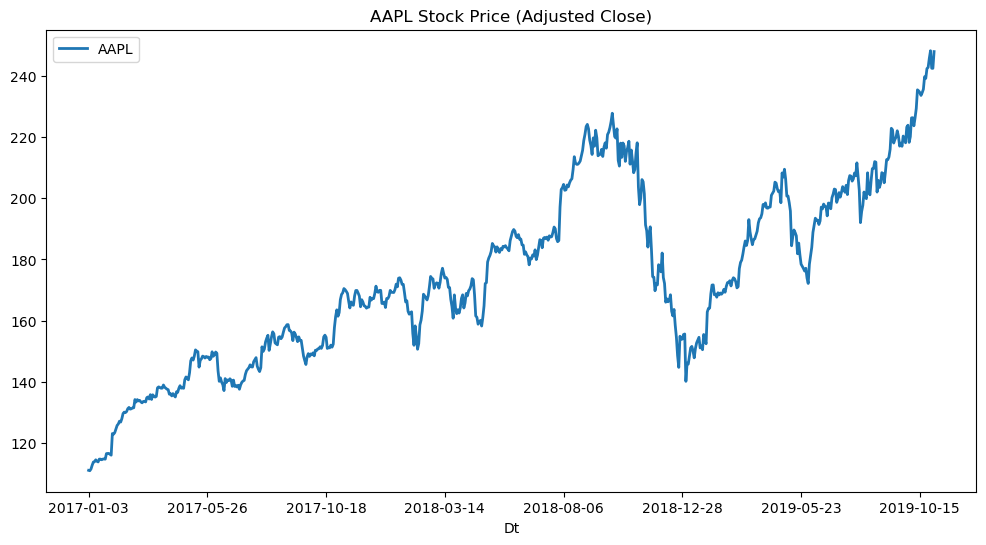

In [59]:
plt.figure(figsize=(12, 6))
data['AAPL_Adj_Close'].plot(label="AAPL", linewidth=2)
plt.title('AAPL Stock Price (Adjusted Close)')
plt.legend()
plt.show()


## Missing Value Check

In [61]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 AAPL_Adj_Close    0
ACN_Adj_Close     0
ADBE_Adj_Close    0
CRM_Adj_Close     0
CSCO_Adj_Close    0
FB_Adj_Close      0
GOOG_Adj_Close    0
IBM_Adj_Close     0
INTC_Adj_Close    0
MA_Adj_Close      0
MSFT_Adj_Close    0
NVDA_Adj_Close    0
V_Adj_Close       0
XLB_Adj_Close     0
XLE_Adj_Close     0
XLF_Adj_Close     0
XLI_Adj_Close     0
XLK_Adj_Close     0
XLP_Adj_Close     0
XLRE_Adj_Close    0
XLU_Adj_Close     0
XLV_Adj_Close     0
XLY_Adj_Close     0
SPY_Adj_Close     0
dtype: int64


<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Dt'>

Text(0.5, 1.0, 'Missing Data Heatmap')

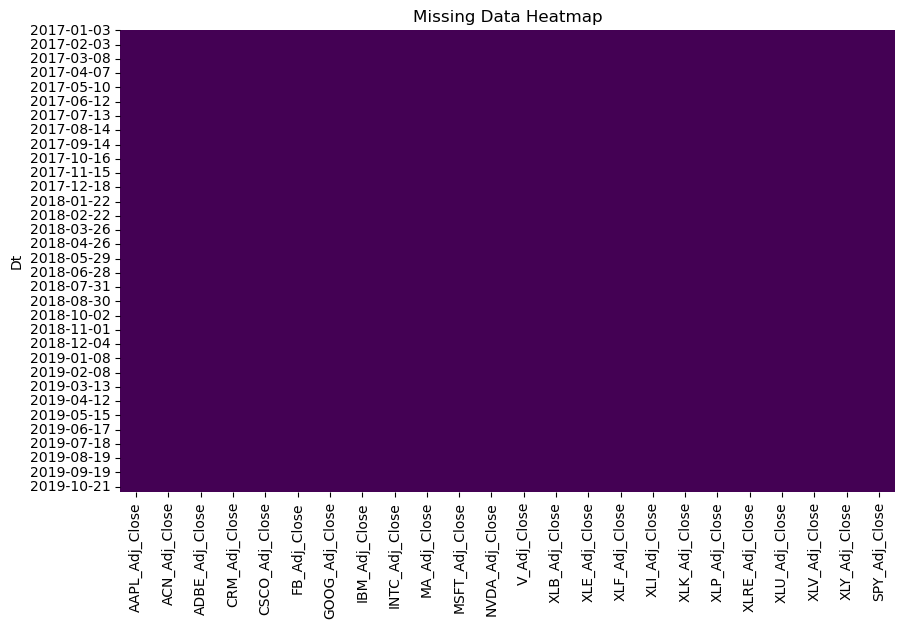

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot missing data heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


## Compute Returns & Check Stationarity

In [64]:
# Compute log returns
returns = np.log(data / data.shift(1)).dropna()

# Define the target variable as AAPL returns
target_ticker = "AAPL_Adj_Close"

# Function to test stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Test for {series.name}: p-value = {result[1]:.5f}")
    return result[1] < 0.05  # If p-value < 0.05, series is stationary

# Apply stationarity test on all returns
stationary_results = {col: check_stationarity(returns[col]) for col in returns.columns}


ADF Test for AAPL_Adj_Close: p-value = 0.00000
ADF Test for ACN_Adj_Close: p-value = 0.00000
ADF Test for ADBE_Adj_Close: p-value = 0.00000
ADF Test for CRM_Adj_Close: p-value = 0.00000
ADF Test for CSCO_Adj_Close: p-value = 0.00000
ADF Test for FB_Adj_Close: p-value = 0.00000
ADF Test for GOOG_Adj_Close: p-value = 0.00000
ADF Test for IBM_Adj_Close: p-value = 0.00000
ADF Test for INTC_Adj_Close: p-value = 0.00000
ADF Test for MA_Adj_Close: p-value = 0.00000
ADF Test for MSFT_Adj_Close: p-value = 0.00000
ADF Test for NVDA_Adj_Close: p-value = 0.00000
ADF Test for V_Adj_Close: p-value = 0.00000
ADF Test for XLB_Adj_Close: p-value = 0.00000
ADF Test for XLE_Adj_Close: p-value = 0.00000
ADF Test for XLF_Adj_Close: p-value = 0.00000
ADF Test for XLI_Adj_Close: p-value = 0.00000
ADF Test for XLK_Adj_Close: p-value = 0.00000
ADF Test for XLP_Adj_Close: p-value = 0.00000
ADF Test for XLRE_Adj_Close: p-value = 0.00000
ADF Test for XLU_Adj_Close: p-value = 0.00000
ADF Test for XLV_Adj_Close: p-

## WHAT I LEARNT
I conducted the Augmented Dickey-Fuller (ADF) test on the adjusted closing prices of multiple stocks and sector indices, including AAPL, ACN, ADBE, CRM, and others, and found that all of them have a p-value of 0.00000. This indicates that the data is stationary, meaning its statistical properties like mean and variance remain constant over time. Since stationarity is a key requirement for regression tasks, I can confidently proceed with regression modeling, knowing that the relationships between variables are stable and reliable for prediction

<Axes: xlabel='AAPL_Adj_Close', ylabel='Count'>

Text(0.5, 1.0, 'AAPL Returns Distribution')

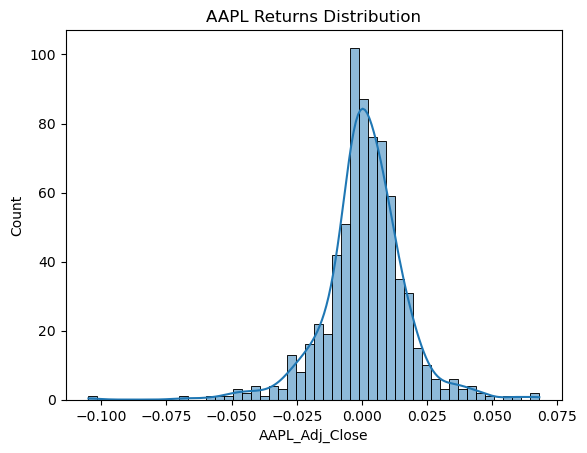

In [66]:
sns.histplot(returns['AAPL_Adj_Close'], kde=True, bins=50)
plt.title('AAPL Returns Distribution')
plt.show()


<Figure size 1200x600 with 0 Axes>

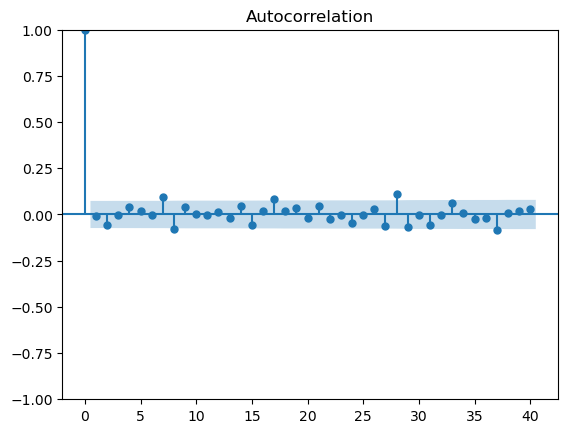

<Figure size 1200x600 with 0 Axes>

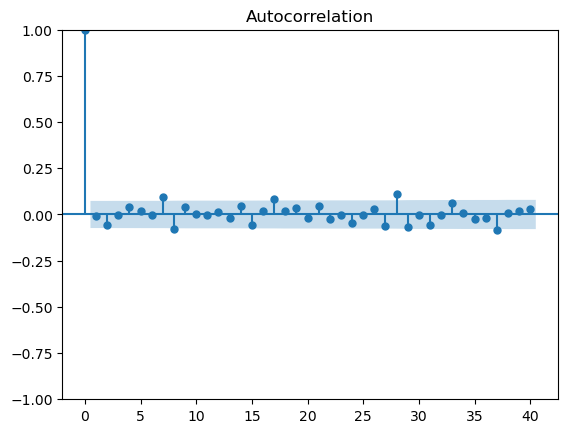

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(returns['AAPL_Adj_Close'], lags=40)
plt.show()


<Axes: xlabel='AAPL_Adj_Close'>

Text(0.5, 1.0, 'Box Plot of AAPL Returns')

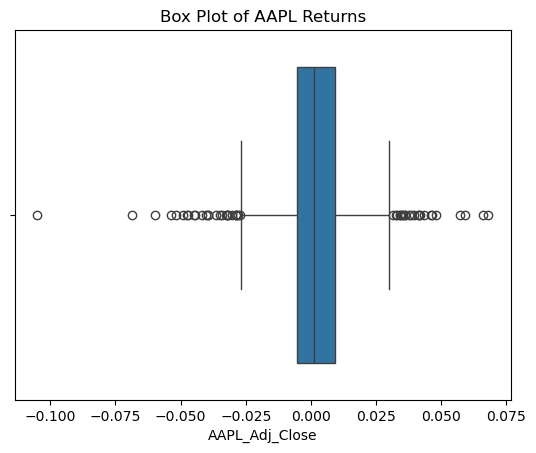

In [68]:
sns.boxplot(x=returns['AAPL_Adj_Close'])
plt.title('Box Plot of AAPL Returns')
plt.show()


## Correlation Analysis

In [70]:
# Compute Pearson correlation with AAPL returns
correlations = returns.corr()[target_ticker].sort_values(ascending=False)
print("Pearson Correlations with AAPL:\n", correlations)

# Compute Spearman correlation (non-linear relationships)
spearman_corr = returns.corr(method="spearman")[target_ticker].sort_values(ascending=False)
print("Spearman Correlations with AAPL:\n", spearman_corr)

# Mutual Information for nonlinear dependencies
X = returns.drop(columns=[target_ticker])  # Remove AAPL from features
y = returns[target_ticker]
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Mutual Information Scores:\n", mi_scores)


Pearson Correlations with AAPL:
 AAPL_Adj_Close    1.000000
XLK_Adj_Close     0.817499
SPY_Adj_Close     0.709819
XLY_Adj_Close     0.646822
MSFT_Adj_Close    0.630844
MA_Adj_Close      0.615657
GOOG_Adj_Close    0.610930
V_Adj_Close       0.601037
XLI_Adj_Close     0.568323
ADBE_Adj_Close    0.547304
CRM_Adj_Close     0.547094
CSCO_Adj_Close    0.546708
XLB_Adj_Close     0.522471
XLV_Adj_Close     0.519837
INTC_Adj_Close    0.512820
ACN_Adj_Close     0.511063
NVDA_Adj_Close    0.505796
XLF_Adj_Close     0.489705
FB_Adj_Close      0.466880
XLE_Adj_Close     0.432081
IBM_Adj_Close     0.391996
XLP_Adj_Close     0.348469
XLRE_Adj_Close    0.267397
XLU_Adj_Close     0.076658
Name: AAPL_Adj_Close, dtype: float64
Spearman Correlations with AAPL:
 AAPL_Adj_Close    1.000000
XLK_Adj_Close     0.777782
SPY_Adj_Close     0.662235
GOOG_Adj_Close    0.592117
MSFT_Adj_Close    0.584160
XLY_Adj_Close     0.576189
MA_Adj_Close      0.553624
CSCO_Adj_Close    0.531759
NVDA_Adj_Close    0.524528
V_Adj

## New Learning
The Pearson correlation test measures the linear relationship between AAPL_Adj_Close and other stocks, showing strong positive correlations with XLK_Adj_Close (0.817), SPY_Adj_Close (0.710), and XLY_Adj_Close (0.647), while weak correlations with XLU_Adj_Close (0.077) and XLRE_Adj_Close (0.267); the Spearman correlation test, which measures monotonic relationships, similarly indicated strong positive correlations with XLK_Adj_Close (0.778) and SPY_Adj_Close (0.662), with weak correlations for XLU_Adj_Close (0.065) and XLRE_Adj_Close (0.230); and the Mutual Information test, which evaluates shared information between variables, revealed the highest information shared with XLK_Adj_Close (0.587) and SPY_Adj_Close (0.431), with XLU_Adj_Close (0.013) showing minimal shared information

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

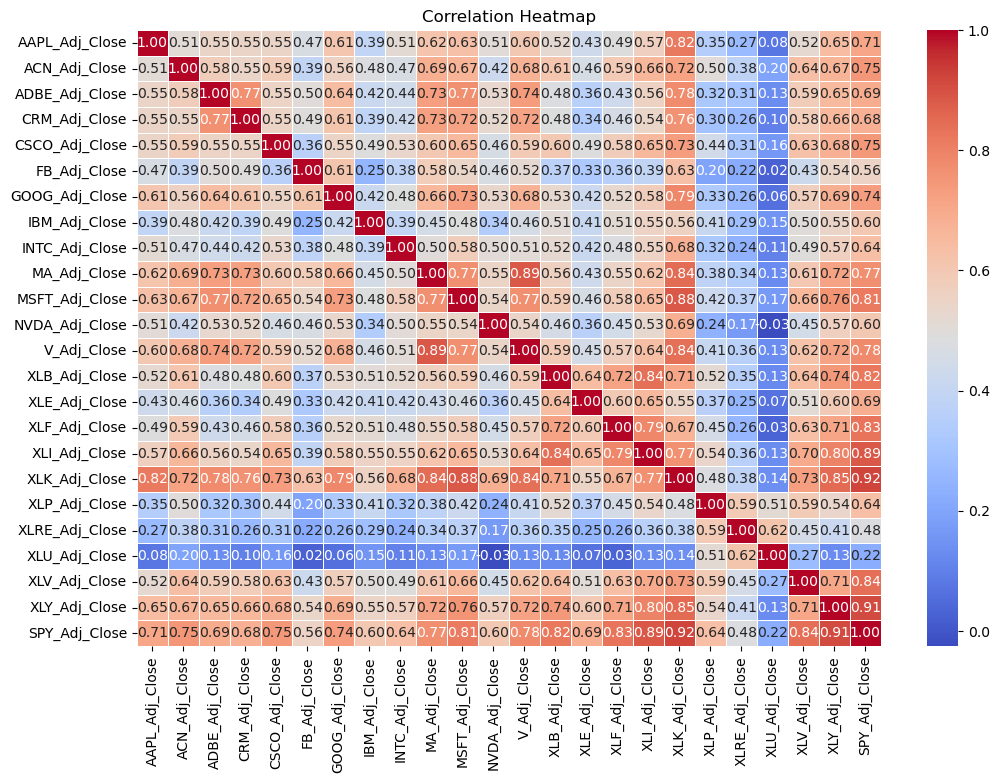

In [72]:
plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [73]:
# Compute Pearson correlation with AAPL returns
correlations = returns.corr()[target_ticker].sort_values(ascending=False)

# Set correlation threshold (absolute value)
corr_threshold = 0.62

# Select features with strong correlation to AAPL
selected_features_corr = correlations[abs(correlations) >= corr_threshold].index.tolist()
selected_features_corr.remove(target_ticker)  # Remove target from features

print(f"Selected features based on Pearson correlation (|r| ≥ {corr_threshold}):\n", selected_features_corr)

# Filter dataset to keep only selected features
X_corr_filtered = returns[selected_features_corr]
y = returns[target_ticker]


Selected features based on Pearson correlation (|r| ≥ 0.62):
 ['XLK_Adj_Close', 'SPY_Adj_Close', 'XLY_Adj_Close', 'MSFT_Adj_Close']


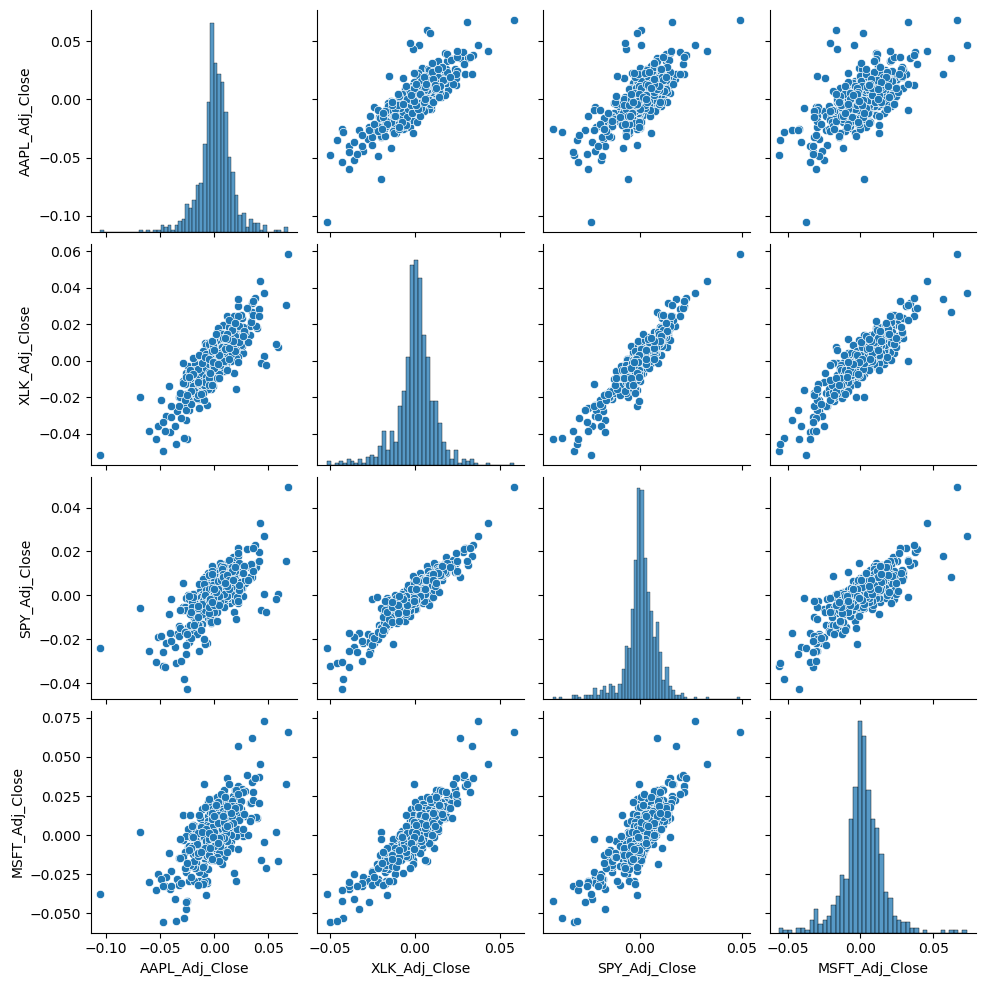

In [74]:
sns.pairplot(returns[['AAPL_Adj_Close', 'XLK_Adj_Close', 'SPY_Adj_Close', 'MSFT_Adj_Close']])
plt.show()


## Correlation Threshold

I am considering onlt those variables that have a greater predictive power based on the correlation scores. This I beleive will help reduce noise in the model.

In [76]:
from sklearn.preprocessing import StandardScaler

# Standardize the selected features (X_corr_filtered)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr_filtered)

# Check the scaled data shape
print(X_scaled.shape)


(712, 4)


In [77]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)  # Keep 2 components based on your correlation analysis
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
print("Explained variance by PCA components:", pca.explained_variance_ratio_)


Explained variance by PCA components: [0.89351036 0.06676794]


### What did I learn?
I learned the following from this code: First, I standardized the selected features (X_corr_filtered) using StandardScaler to ensure they all have a mean of 0 and a standard deviation of 1. This step is important for PCA, as it is sensitive to the scale of the data. After scaling, I applied Principal Component Analysis (PCA) to reduce the dimensionality of the data, setting n_components=2 to keep the top two principal components. PCA transforms the data into a new coordinate system where the axes (principal components) represent directions of maximum variance. The explained variance ratio shows how much variance each principal component captures from the data. The output reveals that the first principal component captures 89.35% of the variance, while the second component captures 6.68%. This suggests that most of the variability in the data is captured by the first principal component, and the second component adds a smaller but still notable amount of additional information.

## Split the data into Train and Test sets

In [80]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Check the shapes of the train/test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(569, 2) (143, 2) (569,) (143,)


In [81]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Print the coefficients of the model
print("Model Coefficients:", model.coef_)


LinearRegression()

Model Coefficients: [ 6.32281667e-03 -2.58418000e-05]


## I learnt something new about PCA Variables and Correlation
I learned that after performing PCA on the selected features, the principal components (PC1 and PC2) are linear combinations of the original features. Despite the individual features being highly correlated with AAPL, the principal components can have different signs. The negative coefficient for PC2 indicates an inverse relationship with AAPL returns, even though the features that contributed to PC2 were positively correlated with AAPL. This highlights that PCA prioritizes capturing variance, which can result in complex patterns, including negative coefficients for the components.


## 5-Fold Cross Validation

In [84]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_pca, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive RMSE and calculate average
avg_cv_rmse = (-cv_scores.mean())**0.5
print(f"Average Cross-Validation RMSE: {avg_cv_rmse:.3f}")


Average Cross-Validation RMSE: 0.011


#### I learned that the average cross-validation RMSE is 0.011, which gives an overall indication of the model's performance across different data splits. 

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Learning Curve')

Text(0.5, 0, 'Training Set Size')

Text(0, 0.5, 'Root Mean Squared Error')

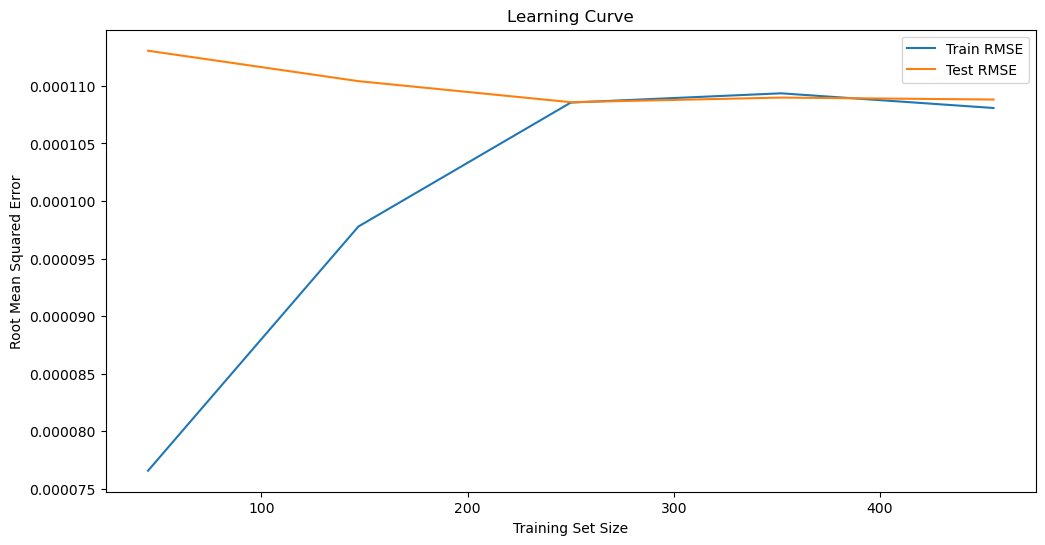

In [86]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, label='Train RMSE')
plt.plot(train_sizes, test_scores_mean, label='Test RMSE')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()


## In-Sample and Out-of-Sample RMSE

In [88]:
from sklearn.metrics import root_mean_squared_error

# In-sample RMSE (on training data)
y_train_pred = model.predict(X_train)
in_sample_rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"In-Sample RMSE: {in_sample_rmse:.3f}")

# Out-of-sample RMSE (on test data)
y_test_pred = model.predict(X_test)
out_sample_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Out-of-Sample RMSE: {out_sample_rmse:.3f}")


In-Sample RMSE: 0.010
Out-of-Sample RMSE: 0.011


# Conclusion
The RMSE values are relatively low, with an in-sample RMSE of 0.010 and an out-of-sample RMSE of 0.011. These values suggest that the model is performing well, as the errors are small, indicating reasonable predictive accuracy. The small difference between in-sample and out-of-sample RMSE implies that the model is generalizing well to unseen data. 

In [90]:
print("Done!")

Done!
